Examine distribution of features for each class in v4 vs v7a of the dataset.

In [ ]:
from thex_data.data_init import *
from thex_data.data_consts import ROOT_DIR, DATA_PATH
from models.binary_model.binary_model import BinaryModel
from models.ind_model.ind_model import OvAModel
from models.multi_model.multi_model import MultiModel


########## PARAMS TO SET 

mags = ["g_mag",  "r_mag", "i_mag", "z_mag", "y_mag",
        "W1_mag", "W2_mag",
        "J_mag", "K_mag", "H_mag"]

V7_VERSION = "a"

########## 



v7mags = []
v4mags = []
for i in mags:
    v4mags.append(i + "_v4")
    v7mags.append(i + "_v7")
# v4
df_v4ab = collect_data(ROOT_DIR + "/../../data/catalogs/v4ab/assembled-magcols.fits")
# v7
df_v7 = collect_data(
    ROOT_DIR + "/../../data/catalogs/v7/THEx-assembled-v7.1" + V7_VERSION + "-mags-legacy-xcalib-minxcal.fits")

# Join v4 and v7 by 'name'
merged_df = df_v4ab.merge(right=df_v7, how='inner', on=['name'], suffixes=['_v4', '_v7'])

# get the column of labels for each
v4_labels_list = merged_df['claimedtype_v4'].tolist()
v7_labels_list = merged_df['claimedtype_v7'].tolist()


# Only keep rows whose labels did not change
keep_indices = []
for index, row in merged_df.iterrows():
#     enumerate(v4_labels_list):
    v4_label = row['claimedtype_v4']
    v7_label = row['claimedtype_v7']
#     v7_label = v7_labels_list[index]
    
    if v7_label == v4_label:
        keep_indices.append(index) 
reduced_df = merged_df.loc[keep_indices]
if not (reduced_df['claimedtype_v4'] == reduced_df['claimedtype_v7']).all():
    raise ValueError("All labels should now be the same.")
reduced_df['claimedtype'] = reduced_df['claimedtype_v4']


In [ ]:
# Drop all rows which have invalid feature values in the v4 and/or in v7 
# Note: Some features go from being valid to invalid, so these must be dropped 
#  (to ensure we are left with identical datasets)
new_merged_df = reduced_df.copy()
import pandas as pd
# v4_feature = 'y_mag_v4'
# v7_feature = 'y_mag_v7'

keep_indices = []
for index,row in new_merged_df.iterrows():
    drop_row = False
    for feature in mags:
        v4_feature = feature+ '_v4'
        v7_feature = feature+ '_v7'
        if  pd.isnull(row[v4_feature]) or pd.isnull(row[v7_feature]):
            drop_row = True
    if drop_row == False:
        keep_indices.append(index) 
new_merged_df = new_merged_df.loc[keep_indices]
    


In [ ]:
print("Old size " + str(reduced_df.shape))
print("New size " + str(new_merged_df.shape))

In [ ]:

# Run on v4 features
print("V4 Run")
v4_model = MultiModel(
    folds=40,
    min_class_size=40,
    transform_features=True,
    cols=v4mags,
    data=new_merged_df,
)

# v4_model.visualize_data()




In [ ]:
# Run on v7 features
print("V7 Run")
v7_model = MultiModel(
    folds=40,
    min_class_size=40,
    transform_features=True,
    cols=v7mags,
    data=new_merged_df,
)
# v7_model.visualize_data()

In [ ]:
# Note, if I did NOT drop rows which went from valid values to invalid ones in v7, 
# I would have more data , the following counts:
# Class Counts
# Unspecified Ia : 4198
# Unspecified Ia Pec : 83
# Ia-91T : 98
# Ia-91bg : 63
# Ia-HV : 41
# Ic : 180
# Ib/c : 57
# Unspecified Ib : 84
# IIb : 47
# Unspecified II : 1605
# II P : 322
# IIn : 163
# TDE : 54

## table creation
Create table like this with info per class
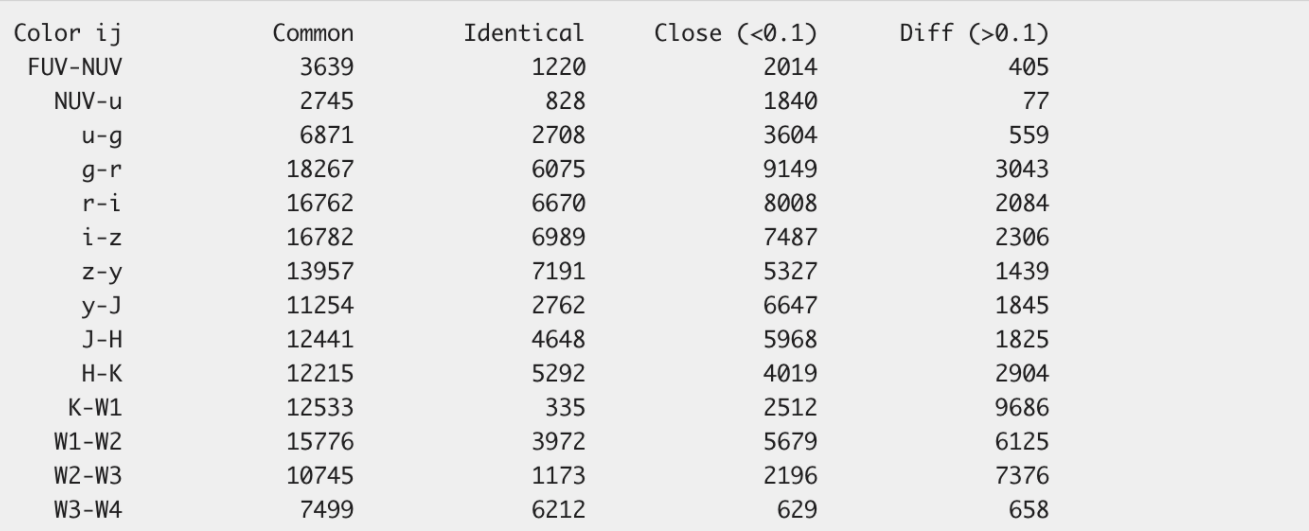

In [ ]:
from thex_data.data_consts import ORDERED_MAGS
def get_color_diffs(df, vn):
    """
    Subtracts adjacent color bands from one another and saves result in new columns, labeled as differences between two
    :param df: DataFrame of features
    """
    features = list(df)
    for index, colname1 in enumerate(features):
#         colname1 
        if colname1[:-3] in ORDERED_MAGS and vn in colname1:
            colname2 = ORDERED_MAGS[colname1[:-3]]  
            if colname2+vn in features:  
                primary_mag = df[colname1]
                prev_mag = df[colname2+vn]
                new_col_name = colname2+vn + "_minus_" + colname1
                df[new_col_name] = primary_mag - prev_mag 

    return df

In [ ]:
from utilities import utilities as util
from thex_data.data_filter import filter_data
from thex_data.data_prep import get_data, get_source_target_data
from thex_data.data_transform import transform_features



data_filters = {'cols': None,  # Names of columns to filter on; default is all numeric cols
                'col_matches': None,  # String by which columns will be selected
                'num_runs': None,  # Number of trials
                'folds': None,  # Number of folds if using k-fold Cross Validation
                'transform_features': True,  # Derive mag colors & scale
                'min_class_size': 9,
                'max_class_size': None,
                'pca': None,  # Number of principal components
                'class_labels': None,
                'data': None,  # Single Pandas DataFrame of data to use
                'nb': False,  # Naive Bayes multiclass
                'priors': None,  # Priors in order of class_labels
                'data_file': DATA_PATH  # Default data file used
                } 
user_data_filters = {'folds' :40,
                    'min_class_size':40,
                    'transform_features':True,  
                    'data':new_merged_df,
}

for data_filter in user_data_filters.keys():
    data_filters[data_filter] = user_data_filters[data_filter]

    
# get data and apply filtering as done in model

X, y=get_source_target_data(data_columns=v4mags + v7mags, 
                       data_filters=data_filters)

X = get_color_diffs(X, "_v4")
X = get_color_diffs(X, "_v7")

new_y = util.add_unspecified_labels_to_data(y, v4_model.class_levels)

new_X, new_y = filter_data(X, new_y, data_filters, v4_model.class_labels, v4_model.class_hier)

if v4_model.X.shape[0] == new_X.shape[0]:
    print("All correct.")

In [ ]:
# Calculate how values have changed

import pandas as pd

mag_results = {}
for mag in mags:
    if mag == 'g_mag':
        continue
    full_X = new_X
    full_y = new_y
    class_labels = v4_model.class_labels
    # Get mag name as color ;value - key
    color = ORDERED_MAGS[mag] + " - " + mag  
    v4_color = ORDERED_MAGS[mag] + "_v4_minus_" + mag + "_v4"
    v7_color = ORDERED_MAGS[mag] + "_v7_minus_" + mag + "_v7"

    # Make table
    identical = {cn : 0 for cn in class_labels}
    close = {cn : 0 for cn in class_labels}
    far = {cn : 0 for cn in class_labels}

    for index, row in full_X.iterrows():
        row_labels = full_y['transient_type'].loc[index]

        for class_name in class_labels:
            if class_name in util.convert_str_to_list(row_labels):
                # Get color
                if row[v7_color] == row[v4_color]:
                    identical[class_name] +=1
                elif abs(row[v7_color] - row[v4_color]) < 0.1:
                    close[class_name] +=1
                elif abs(row[v7_color] - row[v4_color]) >= 0.1:
                    far[class_name] +=1
                break
    
    mag_results[color] = [identical, close, far]
                

In [ ]:
 
#     Save all in DataFrame
final_cols = ['class name', 'color', 'identical', 'close <0.1', 'far >0.1']
final_df = pd.DataFrame(columns=final_cols)
for class_name in class_labels:
    
    for color_key in mag_results:
        # get dicts (over classes)
        identical, close, far = mag_results[color_key] 
        row_data=[class_name, color_key, identical[class_name], close[class_name], far[class_name]]
        a=pd.DataFrame([row_data], columns=final_cols)
        final_df=final_df.append(a)
    

In [ ]:
final_df

In [ ]:
final_df.to_csv("v4_to_v7" + V7_VERSION +"_data_changes.csv")


# pd.DataFrame([identical, close], columns = ["identical", "close"])

In [ ]:

final_df = pd.DataFrame(columns=['color', 'identical', 'close <0.1', 'far >0.1'])
a=pd.DataFrame([['g', 3, 3, 3]], columns=['color', 'identical', 'close <0.1', 'far >0.1'])
final_df=final_df.append(a)
# final_df=final_df.append([['g', 3, 3, 3]])

In [ ]:
final_df

In [ ]:
full_X.var()

In [ ]:
far

In [ ]:
final_df = pd.DataFrame(columns=['color', 'identical', 'close <0.1', 'far >0.1'])
final_df

In [ ]:
from thex_data.data_transform import *
a = pd.DataFrame(columns=mags)
a
b=derive_diffs(a)
b